# Image Classification using Convolutional Neural Networks

Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [0]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
# use GPU if its available, else use cpu for local development
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Type of device currently in use:",device)

Type of device currently in use: cuda


-----
## Configuration
### Hyper Parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. numbper of epoches
5. out put directory

In [0]:
# Hyper-parameters 
learning_rate = 0.001
epochs = 20
batch_train = 4
batch_test = 4


We will output our training images in the "./data" directory

In [0]:
path = "data"
if not os.path.exists(path):
    os.makedirs(path)

-----
##  Data Loading
Next, we are going to load our data. 
### We need to prepare our data:

### We first import necessary librarys for data loading

In [0]:
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

-----
# 1. Program a data loader for CIFAR-10 dataset:
###  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data.
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both training set and testting set. Note that the testing spilit do not require any transform

In [0]:
#Transform Data into tensors of normalized range [-1, 1]
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#we only need to normalize the test set, no need for the transformationss defined for the training set
transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [7]:
trainset = torchvision.datasets.CIFAR10(
    root=path, 
    train=True, 
    download=True,
    transform=transform_train
     )
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_train, 
    shuffle=True, 
    num_workers=2
    )

testset = torchvision.datasets.CIFAR10(
    root=path, 
    train=False, 
    download=True, 
    transform=transform_test
    )
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_test, 
    shuffle=False, 
    num_workers=2)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


-----
# 2. Built a CNN model for classification:
##  Network
Next, we are going to design our GoogLeNet
### First, we define our GoogLeNet class
### You need to refer the paepr below to understand the structure.
### https://arxiv.org/abs/1409.4842






------
### Inception Module with dimension reductions (There exist many implement methods)
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of tow 2D convaluations, two 2D batch normalization layers and tow ReLU activation functions
    
    5. b3 is a block consists of three 2D convaluations, three 2D batch normalization layers and three ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

In [0]:
# Create a Class that defines a Convolution after normalization and activation
class Convolution(nn.Module):
    def __init__(self, input_cls, output_cls, **kwargs):
      super(Convolution, self).__init__()
      self.relu = nn.ReLU()
      self.conv = nn.Conv2d(input_cls, output_cls, **kwargs)
      self.batchnorm = nn.BatchNorm2d(output_cls)
      
    def forward(self, x):
      return self.relu(self.batchnorm(self.conv(x)))


#Our Inception Module Implementation
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pooling_planes):
                # self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes
      #Mandatory super initialization of the Class
      super(Inception, self).__init__()

      # 1x1 conv branch
      self.b1 = Convolution(in_planes,kernel_1_x,kernel_size=1)

      # 1x1 conv -> 3x3 conv branch
      self.b2 = nn.Sequential(
          Convolution(in_planes,kernel_3_in,kernel_size=1),
          Convolution(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
      )

      # 1x1 conv -> 5x5 conv branch
      self.b3 = nn.Sequential(
          Convolution(in_planes, kernel_5_in, kernel_size=1),
          Convolution(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
          Convolution(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
      )

      # 3x3 pool -> 1x1 conv branch
      self.b4 = nn.Sequential(
          nn.MaxPool2d(3, stride=1, padding=1),
          Convolution(in_planes, pooling_planes, kernel_size=1),
      )
    def forward(self,x):
      b1_y = self.b1(x)
      b2_y = self.b2(x)
      b3_y = self.b3(x)
      b4_y = self.b4(x)
      return torch.cat([b1_y,b2_y,b3_y,b4_y],1)




### <a href="https://arxiv.org/abs/1409.4842">GoogLeNet Module</a> 



1. Create a python class called GoogLeNet which inherits nn.module

2. Create a init function to init this python class

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convaluation with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    3. Two Inception block
    
    4. Maxpooling layer
    
    5. Seven Inception block
    
    6. Average Pooling layer
    
    7. A fully connected layer.
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the output

In [0]:
class GoogleNet(nn.Module):
      def __init__(self):
        super(GoogleNet, self).__init__()

        self.init_conv = Convolution(3,192,kernel_size=3,padding=1)
        self.I1 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.I2 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.I3 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.I4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.I5 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.I6 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.I7 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.I8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.I9 = Inception(832, 384, 192, 384, 48, 128, 128)
        self.a_pool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

      def forward(self, x):
        result = self.init_conv(x)
        result = self.I1(result)
        result = self.I2(result)
        result = self.maxpool(result)
        result = self.I3(result)
        result = self.I4(result)
        result = self.I5(result)
        result = self.I6(result)
        result = self.I7(result)
        result = self.maxpool(result)
        result = self.I8(result)
        result = self.I9(result)
        result = self.a_pool(result)
        result = result.view(result.size(0), -1)
        result = self.linear(result)
        return result


### Next, we create the networka and send it to the target device

In [11]:
myCNN = GoogleNet().to(device)
print(myCNN)

GoogleNet(
  (init_conv): Convolution(
    (relu): ReLU()
    (conv): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (I1): Inception(
    (b1): Convolution(
      (relu): ReLU()
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (b2): Sequential(
      (0): Convolution(
        (relu): ReLU()
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Convolution(
        (relu): ReLU()
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (b3): Sequential(
      (0): Convo

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(myCNN.parameters(), lr=learning_rate)
# every step, the scheduler decreases the optimizer's learning by 10^-1 every 5 steps
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

-----
# 3-4 : Write training and testing framework to implement and evaluate classification pipeline.
##  Training
Then, we are going to train our Network

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimzier
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

In [15]:
#Lets log our training progress in a txt file 
filename = 'training.txt'

if os.path.exists(filename):
    append_write = 'a' # append if already exists
else:
    append_write = 'w' # make a new file if not

training_log = open(filename,append_write)
training_log.write(f'GoogleNet CNN TRAINING Progress for {epochs} epochs \n')
# training_log.close()


n_total_steps = len(trainloader)
losses = []
accuracy = []

print(f'GoogleNet CNN TRAINING Progress for {epochs} epochs \n')
for epoch in range(epochs):

  scheduler.step()
  print('Epoch:', (epoch+1),'LR:', scheduler.get_lr())
  for i, (train_img, train_label) in enumerate(trainloader):



      # we pass our data and labels to the cuda device
      train_img = train_img.to(device)
      train_label = train_label.to(device)

      #reset parameters
      optimizer.zero_grad()
      # Forward pass
      predicted_label = myCNN(train_img)

      #Calculate the loss
      loss = criterion(predicted_label, train_label)

      # Backward and optimize
      
      loss.backward()
      optimizer.step()

      # We print a log to monitor our progress
      if (i+1) % 500 == 0:
        print (f'Epoch {epoch+1}, Step {i+1}/{n_total_steps}, Loss: {loss.item():.4f}')
      training_log.write(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f} \n')
      
      # print (f'Epoch [{epoch+1}], Step {i+1}/{n_total_steps}, Loss: {loss.item():.4f}')

      # we append our losses to the losses array for future use
      losses.append(loss.item())
      

  #we test our accurracy per epoch trained
  with torch.no_grad():

    #set the total  and correct samples to 0
    n_correct = 0
    n_samples = 0

    for images,labels in testloader:
      
      # we pass the images and the labels to the cuda devicee
      images = images.to(device)
      labels= labels.to(device)

      #we predict using our CNN and get the result using torch.max()
      test_result = myCNN(images)
      values,predictions = torch.max(test_result,1)


      # we determine the current accuracy of our prediction
      for i in range(len(predictions)):
        if (labels[i] == predictions[i]):
          n_correct+=1
        n_samples+=1

      #we determine our models accuracy for this epoch and append the result to the accuracy array  
    epoch_acc = 100* (n_correct/n_samples)
    print(f'Epoch Acurracy {epoch_acc} \n')
    training_log.write(f'Epoch Acurracy {epoch_acc} \n')
    accuracy.append(epoch_acc)

    #we step our scheduler to decrease the learning rate

      






  








#We save our trained model
PATH = './data/GNet.pth'
torch.save(myCNN.state_dict(), PATH)
training_log.close()


    

GoogleNet CNN TRAINING Progress for 20 epochs 

Epoch: 0 LR: [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch [1], Step 500/12500, Loss: 1.9094
Epoch [1], Step 1000/12500, Loss: 1.5989
Epoch [1], Step 1500/12500, Loss: 1.8148
Epoch [1], Step 2000/12500, Loss: 1.9419
Epoch [1], Step 2500/12500, Loss: 1.9377
Epoch [1], Step 3000/12500, Loss: 1.7665
Epoch [1], Step 3500/12500, Loss: 1.2209
Epoch [1], Step 4000/12500, Loss: 1.1805
Epoch [1], Step 4500/12500, Loss: 1.0520
Epoch [1], Step 5000/12500, Loss: 0.7602
Epoch [1], Step 5500/12500, Loss: 1.1090
Epoch [1], Step 6000/12500, Loss: 0.9258
Epoch [1], Step 6500/12500, Loss: 1.1632
Epoch [1], Step 7000/12500, Loss: 0.6730
Epoch [1], Step 7500/12500, Loss: 1.5535
Epoch [1], Step 8000/12500, Loss: 1.2475
Epoch [1], Step 8500/12500, Loss: 1.5716
Epoch [1], Step 9000/12500, Loss: 0.4054
Epoch [1], Step 9500/12500, Loss: 1.5644
Epoch [1], Step 10000/12500, Loss: 1.3836
Epoch [1], Step 10500/12500, Loss: 1.1273
Epoch [1], Step 11000/12500, Loss: 0.8359
Epoch [1], Step 11500/12500, Loss: 0.3483
Epoch [1], Step 12000/12500, Loss: 0.7829
Epoch [1], S

# Accuracy Results

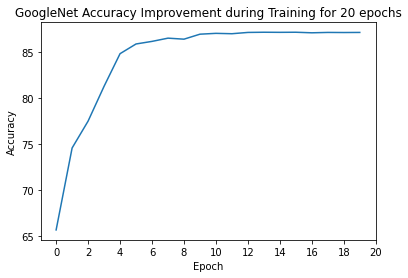

<Figure size 432x288 with 0 Axes>

In [102]:
import matplotlib.pyplot as plt
plt.plot(accuracy)
plt.xticks(np.arange(0,21,2))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'GoogleNet Accuracy Improvement during Training for {epochs} epochs')
plt.show()

# Loss Convergence

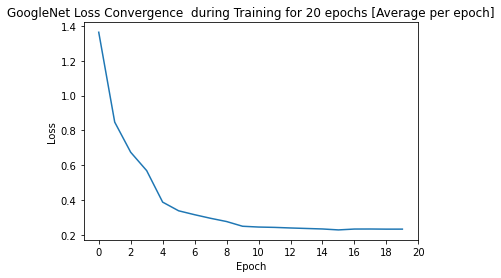

In [105]:
#Get the average loss per epoch
losses_array = np.array(losses)
average_loss_per_echo = np.mean(losses_array.reshape(-1, 12500), axis=1)


plt.plot(average_loss_per_echo)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0,21,2))
plt.yticks(np.arange(0.2,1.5,0.2))

plt.title(f'GoogleNet Loss Convergence  during Training for {epochs} epochs [Average per epoch]')
plt.show()
plt.show()

#5. Write a report to introduce the structure your implement and how it works
## Structure
This CNN follows the GoogleNet's architecture

![alt text](https://i.stack.imgur.com/Xqv0n.png)

I simplified the structure a bit in this implementation by creating three classes instead of two: one Convolution Class, one Inception Class, and one GoogleNet Class.  The Inception class relies on the Convolution Class. And the GoogleNet Class relies on the Convolution Class.

During training, the following happens every epoch:

1. the sheduler is stepped to decrease the learning rate every n steps ( in this case, n is 5).
3. the gradients  are set to zero using the optimizer
2. the labels are predicted and the loss is calculated
3. back propagation occurs using loss.backward()
4. the gradients are updated using optimizer.step()
5. 1-4 is repeated for all batches in the trainloader.
6. after training, the accuracy is calculated using the test data.

## Results Summary 

After training the CNN for 20 epochs, the network managed to achieve an accuracy of 87.11 per cent! Although this results are promising, they are still not up to par with those achieved in the ILSVRC 2014 competition where the GoogleNet Architecture got worldwide recogniton. Both the accuracy graph and the loss convergence graph shown above demonstrate that this network was close to optimal given the current hyperparameters as the graphs are both plateuing after the 10th epoch, which points to the fact that the network was learning very slowly after that.  I believe that the diminshing returns are primarily due to two things: number of epochs and choosen hyperparameters. The hyperparameters chosen for this network are: 
- batch size: 4
- data transforms(random.horizontalflip(),normalization, etc.)
- Learning Rate: 0.001 (with a scheduler that decreases the learning rate by 10^-1 every 5 steps)


In the logs, you can see that whenever the scheduler kicks in, the networks accuracy increases by approximately 3% in the next epoch trained! I believe that if we decrease the scheduler's step size and increase the number of epochs (25-30 epochs) we might achieve an acccuracy 2 to 3% higher.  Something else that might a positive bearing on the results might be the way we transformed data initally, a possible avenue for improvement that I didn't get into. Lastly, it is still possible that the current hyperparameters setting would have yielded better results if I had just trained the CNN for longer. This network was trained for 10 hours, but maybe a few more hours or days of training would have yielded better results.

# Seeing the CNN in Action
As an additional way of ensuring that the CNN is actually able of predicting the classes in the CIFAR-10 dataset, I included the script below, which prints images from the testloader (using the imshow function that is found in Pytorch' documentation)  and compares their actual labels to those predicted by the CNN. As seen below, only one image was misclassified, which is a testament of the network's 87% prediction accuracy rate.  

In [0]:
myCNN.to("cpu")
myCNN.eval()


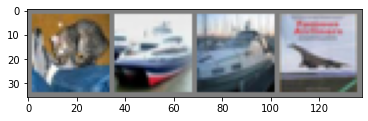

------------------------------------------------------
   Actual Label:  |   cat  ship  ship plane
Predicted Label:  |   cat  ship   car plane
------------------------------------------------------


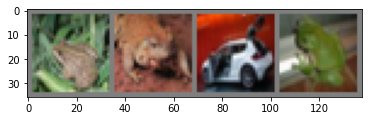

------------------------------------------------------
   Actual Label:  |  frog  frog   car  frog
Predicted Label:  |  frog  frog   car  frog
------------------------------------------------------


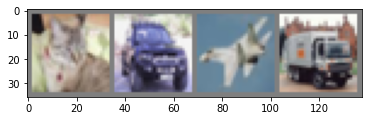

------------------------------------------------------
   Actual Label:  |   cat   car plane truck
Predicted Label:  |   cat   car plane truck
------------------------------------------------------


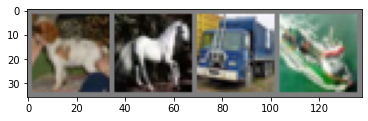

------------------------------------------------------
   Actual Label:  |   dog horse truck  ship
Predicted Label:  |   dog horse truck  ship
------------------------------------------------------


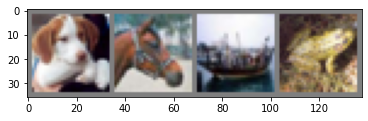

------------------------------------------------------
   Actual Label:  |   dog horse  ship  frog
Predicted Label:  |   dog horse  ship  frog
------------------------------------------------------


In [92]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
  
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(testloader)
for i in range(5):
  images, labels = dataiter.next()
  outputs = myCNN(images)
  _, predicted = torch.max(outputs, 1)

  # print images
  imshow(torchvision.utils.make_grid(images))
  print('------------------------------------------------------')
  print('   Actual Label: ','|', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
  print('Predicted Label: ', '|',' '.join('%5s' % classes[predicted[j]] for j in range(4)))
  print('------------------------------------------------------')

# Additional files

During training, I logged the loss and accuracy metrics per epoch in a file called "training.txt". I also saved the models parameters using torch.save() in a file called "Gnet.pth". This way, I can go back to this same network and continue training it (possibly with better chosen hyperparameters) in order to improve its performance.

Both the "Gnet.pth" and the "training.txt" are included in the  assignment submission's ZIP file. 

# Resources:
- https://www.youtube.com/watch?v=pDdP0TFzsoQ
- Stanford's Lecture on CNNs: https://www.youtube.com/watch?v=bNb2fEVKeEo
- https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb
- https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
- https://web.stanford.edu/class/cs231a/lectures/intro_cnn.pdf
- https://buzzrobot.com/whats-happening-inside-the-convolutional-neural-network-the-answer-is-convolution-2c22075dc68d



